# 7.1 Discriminant functions

In the previous chapter, we explored how to extract a feature vector $\textbf{x} = [x_1, x_2, \ldots, x_n]$ to describe an image object or *region* (e.g. a binary region, a segmented image, $\ldots$). In this chapter, our goal is **to classify the object as belonging to one of $M$ object classes or categories**, according with its feature vector $\textbf{x}$. For that, the space defined by the features in $\textbf{x}$, also referred as **feature space**, is divided into prediction regions. The image below shows an example of those regions in a scenario with categories $C=\{C_1,C_2,C_3\}$, so $M=3$, and features $\textbf{x}=[x_1,x_2]$:
$\\[10pt]$

<img src="./images/clas-space.png" width="300">$\\[3pt]$

Two main steps are needed in order to build an object recognition system and work with it:

- A **training (design) phase**, where sample vectors of known objects are used to learn the classifier (supervised learning).
- A **prediction (online) phase**, where the image objects are classified to one of the classed based on the learned prediction models.

Such prediction models come in two flavors:

- **Statistical classifiers:**
  - It is assumed that the feature vectors $\textbf{x}$ of the classes $C$ follow a **statistical distribution**.
  - The parameters of such distribution need to be **learned from known objects**.
  - Examples: Naïve Bayessian Classifier, Logistic Regression, Conditional Random Fields.  
- **Non-statistical classifiers:**
  - No assumption is made on the statistical distribution of the feature vector.
  - The coefficient of deterministic discriminant functions are learned.
  - Examples: Support Vector Machine, Perceptron, AdaBoost.

This notebook focuses on non-statistical classifiers. Concretely it covers:

- Linear discriminant functions (section 7.1.1).
- Separability (section 7.1.2).
- Generalized discriminant function (section 7.1.3).

## Problem context - Traffic sign recognition

Before self-driving vehicles can truly operate autonomously, they would need to identify traffic signs like "speed limit", "children" or "turn ahead". This problem is called **Traffic Sign Recognition (TSR)** and is faced by companies like Tesla or Google (Waymo), and now by *AliquindoiCars*, a startup located in the Andalusia Technology Park in Málaga.

This is part of the features collectively called *Advanced Driver Assistance Systems (ADAS)*. It uses image processing techniques to detect the traffic signs. The detection methods can be generally divided into color based, shape based and learning based methods. $\\[3pt]$

<img src="./images/signs.jpg" width="400">$\\[3pt]$

Given your growing experience in computer vision, *AliquindoiCars* contacted you asking for a TSR technique to be integrated into a self-driving car. 

### The data

Since most traffic signs in Spain (and in the rest of the world) have a rectangular, circular or triangular shape, they provided you 3 folders containing 20 images each;

- `./images/circles/{0-19}.png`
- `./images/rectangles/{0-19}.png`
- `./images/triangles/{0-19}.png`

These folders contain segmented and binarized images of traffic signs captured by a camera in a car. **Our task is to design a recognition system able to distinguish each type of shape.**

In [38]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
import glob
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)

# images_path = './images/'
images_path = 'Documents/jupyter-notebooks-for-computer-vision/Chapter 07. Object Recognition/images/'

### Computing feature vectors

Prior to describe the methods that will be used to perform recognition, let's build the feature vectors they are going to use. For this, and given your experience, you are going to use the Hu Moments (7-size feature vector).

### **<span style="color:green"><b><i>ASSIGNMENT 1</i></b></span>**

**Your first task is** to obtain a $20x7$ matrix for each type of shape, where rows index images and columns Hu moments. In this way, the $5^{th}$ row in the matrix characterizing rectangular signs would contain the Hu moments computed from the $5^{th}$ image with that shape. 

In order to get a first impression of how these features are distributed in the feature space for the different shapes, plot the results using [`plt.scatter()`](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.scatter.html) (show only the firsts 2 Hu moments).

In [ ]:
# Assignment 1 Part a
def image_moments(region):
    """ Compute moments of the external contour in a binary image.   
    
        Args:
            region: Binary image
                    
        Returns: 
            moments: dictionary containing all moments of the region
    """   
    
    # Get external contour
    
    
    # Compute moments

In [39]:
# Assignment 1 Part a: Solution
def image_moments(region):
    """ Compute moments of the external contour in a binary image.   
    
        Args:
            region: Binary image
                    
        Returns: 
            moments: dictionary containing all moments of the region
    """   
    # Find external contours
    contours, _ = cv2.findContours(region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return np.zeros(7)   # return zeros if no contour found
    
    # Use the largest contour
    c = max(contours, key=cv2.contourArea)
    
    # Compute regular moments
    M = cv2.moments(c)

    # Compute Hu moments
    hu = cv2.HuMoments(M).flatten()
    
    # Log scale transform (optional, helps visualization)
    hu = -np.sign(hu) * np.log10(np.abs(hu) + 1e-10)
    
    return hu

In [ ]:
# Assignment 1 Part b

# Compute Hu moments for circle shape


# Compute Hu moments for square shape


# Compute Hu moments hor triangle shape


# Define plot axis


# Plot firsts two Hu moments


In [47]:
# Assignment 1 Part b: Solution

# ---------- Step 2: Load images & compute Hu moments ----------
shapes = ["circles", "squares", "triangles"]
features = {}

for shape in shapes:
    hu_list = []
    files = sorted(glob.glob(images_path + shape + "/*.png"))
    print(shape, "-> found", len(files), "images")   # debug check
    
    for file in files:
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        hu = image_moments(binary)
        hu_list.append(hu)

    if hu_list:   # if we got at least one image
        features[shape] = np.vstack(hu_list)   # force (N,7)
    else:
        features[shape] = np.empty((0,7))      # empty placeholder


circles -> found 20 images
squares -> found 20 images
triangles -> found 19 images


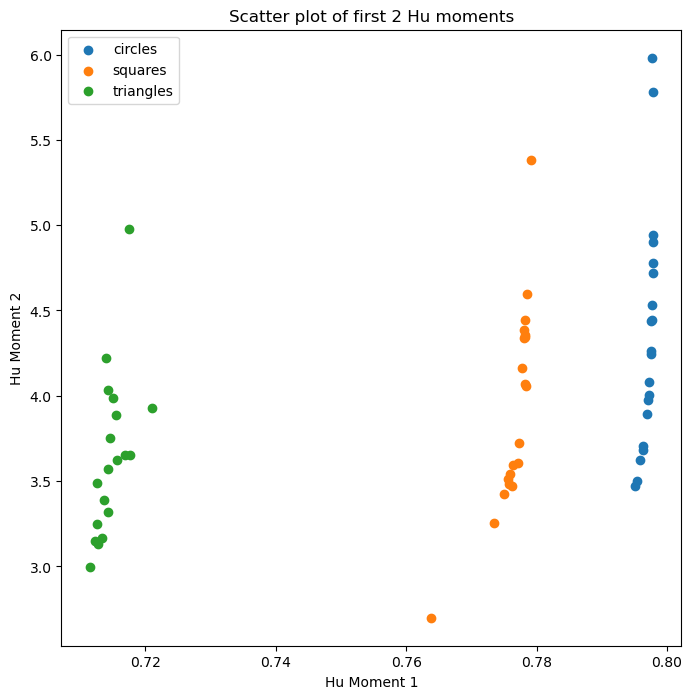

In [57]:
import matplotlib.pyplot as plt
from itertools import cycle

color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

plt.figure(figsize=(8,8))
for shape in shapes:
    A = features[shape]
    if A.shape[0] == 0:
        print(f"⚠ No images for {shape}")
        continue
    plt.scatter(A[:,0], A[:,1], label=shape, c=next(color_cycle))

plt.xlabel("Hu Moment 1"); plt.ylabel("Hu Moment 2")
plt.title("Scatter plot of first 2 Hu moments")
plt.legend(); plt.show()

In [55]:
hu_circles = features['circles']
hu_squares = features['squares']
hu_triangles = features['triangles']

### Interlude

**You must save the computed Hu moments of the segmented data**, since we are going to need them in the next notebook. For saving numPy matrices, you can use [`np.save()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html) (data is saved at `./data/` by default).

In [59]:
np.save("Documents/jupyter-notebooks-for-computer-vision/Chapter 07. Object Recognition/data/hu_circles.npy",hu_circles)
np.save("Documents/jupyter-notebooks-for-computer-vision/Chapter 07. Object Recognition/data/hu_triangles.npy",hu_triangles)
np.save("Documents/jupyter-notebooks-for-computer-vision/Chapter 07. Object Recognition/data/hu_squares.npy",hu_squares)

## 7.1.1 Linear discriminant functions

Taking a look at the scatter plot resultant from the previous assignment, we can see how the three types of signs could be segmented using 2 lines. For example:

<img src="./images/plot_linear.jpg" width="400">$\\[3pt]$

And that's what **linear discriminant functions** do! As we know, a way to define a 2D line is:

$\hspace{2cm} 0 = Ax + By + C\\[3pt]$  
Using another notation:$\\[5pt]$  
$\hspace{2cm}0 = w_1x_1 + w_2x_2 + w_3$$\\[3pt]$  

Note that we can generalize this 2D line to any dimension hyperplane:$\\[5pt]$  
$\hspace{2cm}0 = w_1x_1 + w_2x_2 + \ldots + w_nx_n + w_{n+1}\ =\ \sum_{i=1}^{n+1}w_ix_i$$ \ =\ w^T\cdot x\\[1pt]$  
In this way, we can divide the feature space for any dimension (e.g. n = 7 for Hu moments).

### Working with two classes

If we are considering just two classes $C=\{C_1,C_2\}$, we can define a linear discriminant function as:

$\hspace{2cm} d(\mathbf{x}) = \mathbf{w}^T \cdot \mathbf{x} \ \ \ \ \ \text{(dot product of both vectors)}$

Formally, the vector $w$ is called **weight vector** and we will see a way to compute it automatically from a set of data called **training data**.

In this way, when we have a new object characterized by $\mathbf{x'}$ to classify, $d(\mathbf{x'})$ is computed and:
- If $d(\mathbf{x'})\ge 0$ the new object is assigned $C_1$, and
- if $d(\mathbf{x'})\lt 0$ the object is assigned to $C_2$.

We say that the linear discriminant function $d(\mathbf{x'})$ works as a **decision boundary** between both classes. The following figure illustrates this (blue dots represent characterized objects belonging to $C_1$, while red ones those belonging to $C_2$):

<img src="./images/linear_discriminant_function_2_categories.png" width="250">$\\[3pt]$

### **<span style="color:green"><b><i>ASSIGNMENT 2</i></b></span>**

Let's play a bit with a toy example of a linear discriminant function. Consider that the learned weights during the training phase of the classifier are $\mathbf{w} = [1,0,-3]$, so the linear discriminant function looks like $d(\mathbf{x}) = 1x_1 + 0x_2 -3$. 

**Your task is** to classify some 2D data using the previous discriminant function, plotting them with different colors depending on their assigned class. 

*Tip: [how to color a data point using its class](https://stackoverflow.com/questions/43579626/pandas-plot-with-positive-values-one-color-and-negative-values-another)*.

In [ ]:
# Assignment 2

# Define weight vector


# Define data matrix


# Compute class for each data


# Plot classified data


# Plot discriminant line


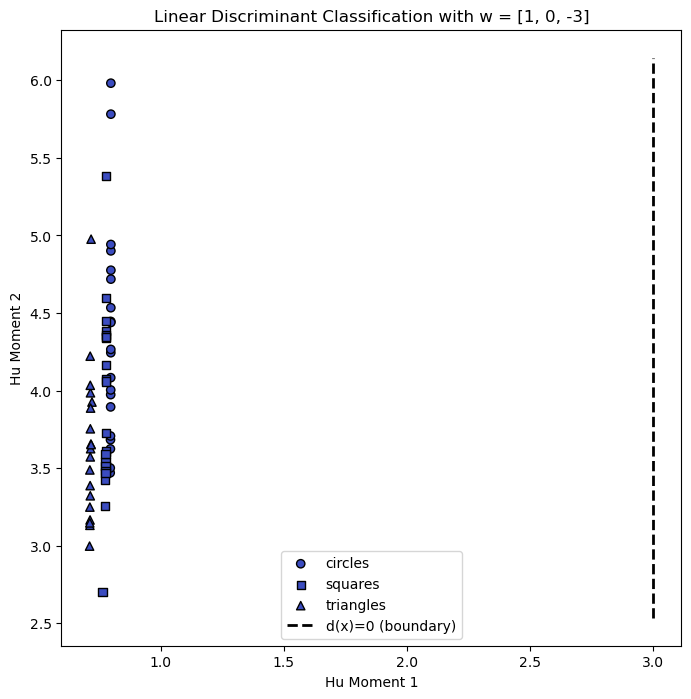

In [65]:
# Assignment 2 Solution (version 1, toy weights)

# Stack features together for toy classification (only use first 2 Hu moments)
X_circles   = hu_circles[:, :2]
X_squares   = hu_squares[:, :2]
X_triangles = hu_triangles[:, :2]

# ---------- Step 2: Define weight vector ----------
# w = [1, 0, -3] → discriminant d(x) = x1 - 3
w = np.array([1, 0, -3])


# ---------- Step 3: Classify data ----------
def classify(X, w):
    # augment with bias 1 column
    X_aug = np.hstack([X, np.ones((X.shape[0], 1))])
    d = X_aug @ w    # linear discriminant
    return (d >= 0).astype(int), d

y_circles, _   = classify(X_circles, w)
y_squares, _   = classify(X_squares, w)
y_triangles, _ = classify(X_triangles, w)

# ---------- Step 4: Plot classified data ----------
plt.figure(figsize=(8,8))

# color points by predicted class
plt.scatter(X_circles[:,0], X_circles[:,1], c=y_circles, cmap="coolwarm", label="circles", marker="o", edgecolor="k")
plt.scatter(X_squares[:,0], X_squares[:,1], c=y_squares, cmap="coolwarm", label="squares", marker="s", edgecolor="k")
plt.scatter(X_triangles[:,0], X_triangles[:,1], c=y_triangles, cmap="coolwarm", label="triangles", marker="^", edgecolor="k")

# ---------- Step 5: Plot discriminant line (x1 = 3) ----------
x2_min, x2_max = plt.ylim()
plt.plot([3, 3], [x2_min, x2_max], 'k--', linewidth=2, label="d(x)=0 (boundary)")

plt.xlabel("Hu Moment 1")
plt.ylabel("Hu Moment 2")
plt.title("Linear Discriminant Classification with w = [1, 0, -3]")
plt.legend()
plt.show()

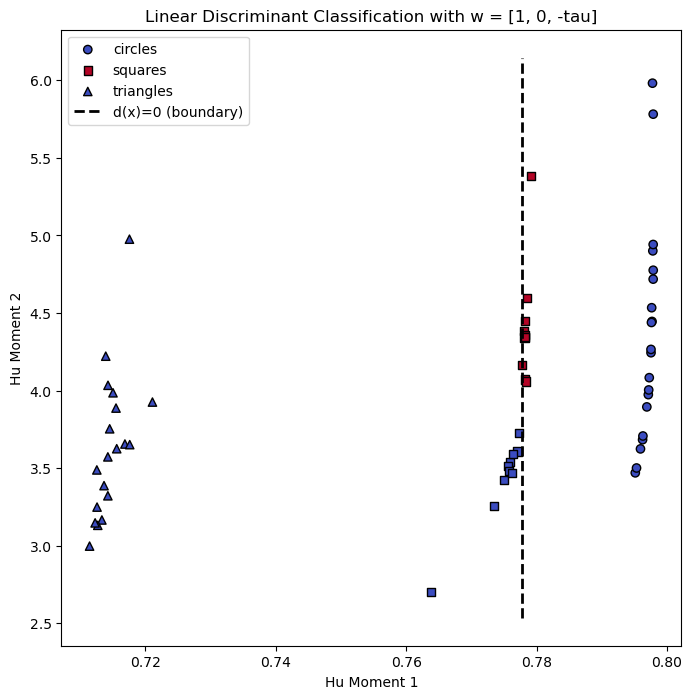

In [66]:
# Assignment 2 Solution (version 2, sensible weights)

# Stack features together for toy classification (only use first 2 Hu moments)
X_circles   = hu_circles[:, :2]
X_squares   = hu_squares[:, :2]
X_triangles = hu_triangles[:, :2]

# ---------- Step 2: Define weight vector ----------
# w = [1, 0, -3] → discriminant d(x) = x1 - 3
# w = np.array([1, 0, -3])

# Rather sensible weights would be
X_all = np.vstack([X_circles, X_squares, X_triangles])
tau = np.median(X_all[:, 0])   # or: X_all[:,0].mean()
w = np.array([1.0, 0.0, -tau]) # d(x) = x1 - tau

# ---------- Step 3: Classify data ----------
def classify(X, w):
    # augment with bias 1 column
    X_aug = np.hstack([X, np.ones((X.shape[0], 1))])
    d = X_aug @ w    # linear discriminant
    return (d >= 0).astype(int), d

y_circles, _   = classify(X_circles, w)
y_squares, _   = classify(X_squares, w)
y_triangles, _ = classify(X_triangles, w)

# ---------- Step 4: Plot classified data ----------
plt.figure(figsize=(8,8))

# color points by predicted class
plt.scatter(X_circles[:,0], X_circles[:,1], c=y_circles, cmap="coolwarm", label="circles", marker="o", edgecolor="k")
plt.scatter(X_squares[:,0], X_squares[:,1], c=y_squares, cmap="coolwarm", label="squares", marker="s", edgecolor="k")
plt.scatter(X_triangles[:,0], X_triangles[:,1], c=y_triangles, cmap="coolwarm", label="triangles", marker="^", edgecolor="k")

# ---------- Step 5: Plot discriminant line (x1 = 3) ----------
x2_min, x2_max = plt.ylim()
plt.plot([tau, tau], [x2_min, x2_max], 'k--', linewidth=2, label="d(x)=0 (boundary)")

plt.xlabel("Hu Moment 1")
plt.ylabel("Hu Moment 2")
plt.title("Linear Discriminant Classification with w = [1, 0, -tau]")
plt.legend()
plt.show()

### Scenarios with N-classes

The previous idea can be generalized to an arbitrary number of classes, defining in that case hyper-planes in a n-dimensional space:

$\hspace{2cm}d(\mathbf{x}) = w_1x_1 + w_2x_2 + \ldots + w_nx_n + w_{n+1}\ =\ \mathbf{w}^T\cdot \mathbf{x}\\[1pt]$  

In this case, the object is assigned to the category which discriminant function returns the highest value. That is:

<img src="./images/linear_discriminant_functions_general_case.png" width="400">$\\[3pt]$

When more than 2 classes are considered, the discriminant functions are no longer the decision boundaries between classes. However, the decision boundary between classes $C_i$ and $C_j$ can be computed as:

$\hspace{2cm}d_{ij}(\mathbf{x}) = d_i(\mathbf{x})-d_j(\mathbf{x})=(\mathbf{w}_i^T-\mathbf{x}_j^T) \cdot \mathbf{x} = \mathbf{w}_{ij}^T \cdot \mathbf{x}$

The following image shows an example with 3 classes (notice that it also exists a decision boundary between classes 1 and 3, $d_{13}(\mathbf{x})$, but it has been omitted for clarity).

<img src="./images/2lines-discriminant.png" width="400">$\\[3pt]$



## 7.1.2 Separability

An important concept regarding object recognition is such of **separability**. In this way, two set of points defining two classes may be separable or not in a given dimension (e.g. $x_1$, $x_2$, etc.).  

Two sets are **linearly separable** if it exists at least one line in the plane that leaves all the points belonging to one class on one side of the line and all those belonging to the second class on the other side. This idea immediately generalizes to higher-dimensional Euclidean spaces if the line is replaced by a hyperplane. 

Some illustrative examples of this:

<img src="./images/separability-2.png" width="900">$\\[3pt]$

- As you can see, those classes are separable. Also, if only dimension $x_1$ is used, we can separate the classes as well. This is not recomended because there isn't a clear separation using only $x_1$, and $x_2$ is also **discriminative**, that is, it also provides valuable information for separating both classes.

<img src="./images/separability-1.png" width="900">$\\[3pt]$

- In this example the classes are not separable as they overlap in both dimensions. Additionally, we can see that $x_1$ is not discriminative as it doesn't provide any information for separating those classes. The addition of a third dimension/feature could fix this!

<img src="./images/separability-3.png" width="900">$\\[3pt]$

- This is an example of a non-linear separable problem. The classes can't be separated using a line, but a **generalized discriminant function** could do it. We will see this later in this notebook.

### Back to sign shape recognition

Back to our traffic sign shape recognition problem, we tried to separate the usual shapes of traffic signs using the Hu moments. As a first approximation to this problem, we plotted the first and second Hu moments ($x_1$ and $x_2$) in order to analyze them. You should have obtained something like this:

<img src="./images/separability-4.png" width="500">$\\[3pt]$

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

**Now you are in a good position to answer these questions:**

- Is this problem linearly separable?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- Are the classes separable using only the first Hu moment ($x_1$)?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- Are the classes separable using only the second Hu moment ($x_2$)?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- Which dimension is more discriminative?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- Would be *AliquindoiCars* guys happy if we propose a solution for shape classification based on linear discriminant functions?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>    

## 7.1.3 Generalized discriminant function

As we saw above, some classes are not separable using a linear discriminant function. In those cases, we may need a **linear basis function model**, also called **generalized discriminant function** (notice that, despite of this, the problem may still not be separable).

The idea behind these discriminant functions is to transform the $\textbf{x}$ space into a $\textbf{x' = f(x)}$ space ($dim(x) \lt dim(x')$):$\\[5pt]$

$\hspace{2cm} \scriptsize   d(x) = w_1\ \color{blue}{f_1(x)} + w_2\ \color{blue}{f_2(x)} + \ldots + w_k\ \color{blue}{f_k(x)} + w_{k+1} = \sum_{i=1}^{k+1}w_i\ \underbrace{\color{blue}{f_i(x)}}_{\scriptsize\text{New space}}=\mathbf{w}^T\cdot \mathbf{f}(\mathbf{x})$

$\hspace{2.75cm}  \scriptsize = w_1\ \color{blue}{x_1'} + w_2\ \color{blue}{x_2'} + \ldots + w_k\ \color{blue}{x_k'} + w_{k+1} = \sum_{i=1}^{k+1}w_i\ \color{blue}{x_i'} = w^T \cdot \color{blue}{x'}=d'(\mathbf{x}')$

Thereby:

$$
\left.\begin{aligned}
        \mathbf{x'} = \mathbf{f}(\mathbf{x}) &= [f_1(\mathbf{x}) \ \ \ f_2(\mathbf{x}) \ \ \ \cdots \ \ \ f_k(\mathbf{x}) \ \ \  1]^T\\
        \mathbf{w} &= [w_1 \ \ \ w_2 \ \ \ \cdots \ \ \ w_k \ \ \ w_{k+1}]^T
       \end{aligned}
 \right\}
 \ \  d(\mathbf{x})= \mathbf{w}^T \cdot \mathbf{x} = \mathbf{w}^T \cdot \mathbf{f}(\mathbf{x})
$$
 
 being $\mathbf{f}(\mathbf{x})$ the basis functions!

### **<span style="color:green"><b><i>ASSIGNMENT 3</i></b></span>**

Let's practice this transformation between spaces. **What to do?** You have to complete the method `transform_space()`, which transforms a set of 2D points into a new space defined by:

$$x' = [x_1^2, \ x_1x_2, \ x_2^2, \ x_1, \ x_2, \ 1]$$

The input set of points is a $[n\_data,2]$ shape matrix and the output is a $[n\_data,6]$ shape matrix, being $n\_data$ the number of points in the set.

In [ ]:
# Assignment 3
def transform_space(data_points):
    """ Compute moments of the external contour in a binary image.   
    
        Args:
            data_points: Input matrix containing a set of 2D points
                    
        Returns: 
            fx: set of points transformed to a quadratic space
    """  


In [67]:
# Assignment 3 Solution

import numpy as np

def transform_space(data_points):
    """
    Map 2D points x = [x1, x2] into the quadratic feature space:
        x' = [x1^2, x1*x2, x2^2, x1, x2, 1]
    
    Parameters
    ----------
    data_points : array-like of shape (n_samples, 2)
        Each row is a point [x1, x2].

    Returns
    -------
    fx : ndarray of shape (n_samples, 6)
        Transformed points.
    """
    # Make sure we have a NumPy array of floats with shape (n, 2)
    X = np.asarray(data_points, dtype=float)
    assert X.ndim == 2 and X.shape[1] == 2, "Input must be (n_samples, 2)."

    x1 = X[:, 0]
    x2 = X[:, 1]

    # Build each column of the transformed space
    col1 = x1**2          # x1^2
    col2 = x1 * x2        # x1*x2
    col3 = x2**2          # x2^2
    col4 = x1             # x1
    col5 = x2             # x2
    col6 = np.ones_like(x1)  # 1

    # Stack columns to form (n_samples, 6)
    fx = np.column_stack([col1, col2, col3, col4, col5, col6])
    return fx


You can use next code to **test if the results are correct**:

In [71]:
# Note: The authors wanted the Expected Output (see below) for the following input, which is not mathematically possible for the given mapping:
# data = np.array([[2,3],[1,2],[2,7],[2,4],[1,5],[2,4]])

# to get the same output, change the input to:
data = np.array([[2,2],[1,2],[2,1],[5,4],[4,5],[4,4]])

x = transform_space(data)

print(x)

[[ 4.  4.  4.  2.  2.  1.]
 [ 1.  2.  4.  1.  2.  1.]
 [ 4.  2.  1.  2.  1.  1.]
 [25. 20. 16.  5.  4.  1.]
 [16. 20. 25.  4.  5.  1.]
 [16. 16. 16.  4.  4.  1.]]


<font color='blue'>**Expected output:**  </font>

     [[ 4.  4.  4.  2.  2.  1.]
     [ 1.  2.  4.  1.  2.  1.]
     [ 4.  2.  1.  2.  1.  1.]
     [25. 20. 16.  5.  4.  1.]
     [16. 20. 25.  4.  5.  1.]
     [16. 16. 16.  4.  4.  1.]]

### **<span style="color:green"><b><i>ASSIGNMENT 4</i></b></span>**

Finally, we will see a toy example of a non-linear discriminant function in action. Concretely, we will consider a quadratic function, $d(x)=x_1^2-5x_2$ (so $k=5$), in a two classes problem with $\mathbf{x}=[x_1 \ \ x_2]$. Thereby, the vector of features in the new space is:

$\hspace{2cm}  \mathbf{x'}=[x_1^2 \ \ x_1x_2 \ \ x_2^2 \ \ x_1 \ \ x_2 \ \ 1]^T $ <br />
so:
- $x_1^2=f_1(\mathbf{x})=x_1'$
- $x_1 x_2=f_2(\mathbf{x})=x_2'$
- and so on.

and the vector of weights turns out to be:

$\hspace{2cm} \mathbf{w}=[1,0,0,0,-5,0]$.

As for the new discriminant function we get:

$\hspace{2cm} d(\mathbf{x}) = w_1 \cdot x_1' + w_5 \cdot x_5'$

**Your task is to classify some 2D data** using the previous discriminant function and plot them coloring each point with a color depending on its class.

*Tip: Remember to transform the data space before applying the dot product.*

In [ ]:
# Assignment 4

# Define weight vector


# Define data matrix


# Trasform from the x space to a f(x) space


# Compute class for each data


# Plot classified data


# Plot discriminant line


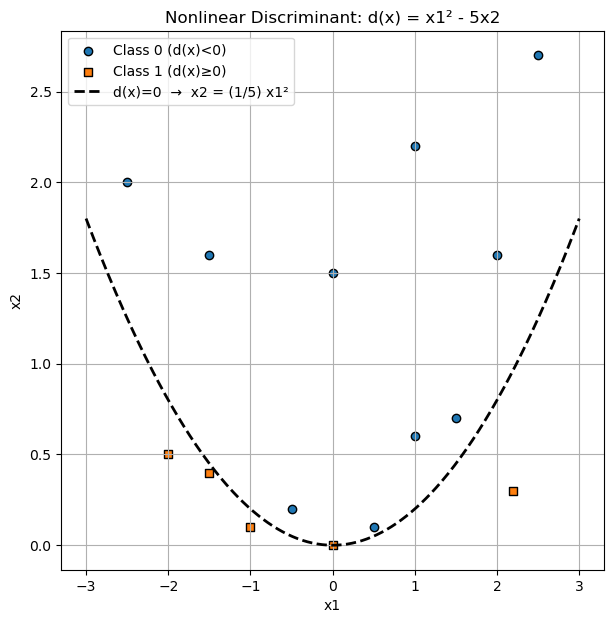

In [72]:
# Assignment 4 Solution

import numpy as np
import matplotlib.pyplot as plt

# --------- helper: quadratic feature map f(x) ---------
def transform_space(data_points):
    """
    Map each 2D point [x1, x2] to:
        [x1^2, x1*x2, x2^2, x1, x2, 1]
    """
    X = np.asarray(data_points, dtype=float)
    x1, x2 = X[:, 0], X[:, 1]
    return np.column_stack([x1**2, x1*x2, x2**2, x1, x2, np.ones_like(x1)])

# ========== Assignment 4 ==========

# 1) Define weight vector
#    For d(x) = x1^2 - 5*x2, only the 1st (x1^2) and 5th (x2) features are used:
#    w = [1, 0, 0, 0, -5, 0]

w = np.array([1.0, 0.0, 0.0, 0.0, -5.0, 0.0])

# 2) Define data matrix (each row is a 2D point [x1, x2])
#    (Feel free to replace with your own points.)
data = np.array([
    [-2.5,  2.0], [-2.0, 0.5], [-1.5, 0.4], [-1.0, 0.1], [-0.5, 0.2],
    [ 0.0,  0.0], [ 0.5, 0.1], [ 1.0, 0.6], [ 1.5, 0.7], [ 2.0, 1.6],
    [ 2.5,  2.7], [ 0.0, 1.5], [ 1.0, 2.2], [-1.5, 1.6], [ 2.2, 0.3]
])

# 3) Transform from the x space to a f(x) space
fx = transform_space(data)         # shape: (n_samples, 6)

# 4) Compute class for each data point using the discriminant d(x) = f(x) · w
scores = fx @ w                    # dot product
y_pred = (scores >= 0).astype(int) # Class 1 if d(x) >= 0, else Class 0

# 5) Plot classified data (in ORIGINAL x-space)
plt.figure(figsize=(7, 7))

# Points with d(x) < 0 (Class 0)
mask0 = y_pred == 0
plt.scatter(data[mask0, 0], data[mask0, 1], label="Class 0 (d(x)<0)",
            marker="o", edgecolor="k")

# Points with d(x) >= 0 (Class 1)
mask1 = y_pred == 1
plt.scatter(data[mask1, 0], data[mask1, 1], label="Class 1 (d(x)≥0)",
            marker="s", edgecolor="k")

# 6) Plot discriminant "line" (it's a parabola in x-space):  x1^2 - 5*x2 = 0
#    => x2 = (1/5) * x1^2
x1_min, x1_max = data[:, 0].min() - 0.5, data[:, 0].max() + 0.5
x1_grid = np.linspace(x1_min, x1_max, 400)
x2_curve = (1.0/5.0) * (x1_grid**2)
plt.plot(x1_grid, x2_curve, "k--", lw=2, label="d(x)=0  →  x2 = (1/5) x1²")

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Nonlinear Discriminant: d(x) = x1² - 5x2")
plt.legend()
plt.grid(True)
plt.show()



## Conclusion

Well done! This was a mostly theoretical notebook, but it described the basis of object classification. You have learned so far:

- how linear and non-linear discriminant functions work,
- to classify objects in a scenario with an arbitrary number of belonging classes using multiple discriminant functions, and
- to check if a feature space allows for the definition of discriminative classifiers looking at the separability between classes.

In the following notebooks in this chapter we will see how to automatically retrieve the weight vector from a set o training data. Exciting, isn't?